In [11]:
from functions.mapGenerator import *
from functions.graphLayout import *
from functions.imageTreatment import *
from functions.dependenciesGenerator import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import random

In [12]:
x = mapDependenciesGenerator(8, 1)
x.generateDependencies()
graph = GraphLayout(x.getDependencies())
graph.addSpecialPoints(num_points=0)
graph.forceDirectedLayout(iterations=10000)
layout = graph.getPositions()
layout_props = graph.getSpecialPositions()

In [13]:
margin_factor = 0.2
map = mapGenerator(graph.getGraph(), layout, margin_factor)
x_coords, y_coords, x_range, y_range, x_grid, y_grid, node_positions = map.getCoordinates()

In [14]:
def grid_search(x_min, x_max, y_min, y_max, points):
    grid = list()
    x_rate = np.linspace(x_min, x_max, points).tolist()
    y_rate = np.linspace(y_min, y_max, points).tolist()
    
    for x in x_rate:
        for y in y_rate:
            grid.append({
                'id': f'{x}:{y}',
                'x': x,
                'y': y,
            })
    
    return grid

In [15]:
def calculate_distance(point, node_position):
    return np.sqrt((point['x'] - node_position[0])**2 + (point['y'] - node_position[1])**2)

In [16]:
def get_closest_grid_point(node_position, grid, grid_size, points_around_distance):
    min_distance = float('inf')
    closest_row, closest_col = -1, -1
    
    for row in range(grid_size):
        for col in range(grid_size):
            point = grid[row * grid_size + col]
            distance = calculate_distance(point, node_position)
            
            if distance < min_distance:
                min_distance = distance
                closest_row, closest_col = row, col
    
    closest_point = grid[closest_row * grid_size + closest_col]

    points_around = []
    for dr in range(-points_around_distance, points_around_distance + 1):
        for dc in range(-points_around_distance, points_around_distance + 1):
            new_row, new_col = closest_row + dr, closest_col + dc
            
            if 0 <= new_row < grid_size and 0 <= new_col < grid_size:
                points_around.append(grid[new_row * grid_size + new_col])
    
    return closest_point, points_around

In [24]:
def calculate_distance_v2(p1, p2):
    # p1 and p2 should be tuples (x1, y1) and (x2, y2)
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def interpolate_points(x1, y1, x2, y2, multiplier=2):
    # Calculate the distance between the two points
    distance = calculate_distance_v2((x1, y1), (x2, y2))
    
    # Calculate the number of points based on the distance * 1.25
    num_points = int(distance * multiplier)
    
    # Determine the midpoint where the L shape will "turn"
    # This will be either horizontally or vertically depending on the relative position of x1, y1 and x2, y2
    if x1 != x2 and y1 != y2:
        # Horizontal line first (x1 to x2), then vertical line (y2 to y1)
        # Create intermediate points between (x1, y1) -> (x2, y1) -> (x2, y2)
        
        # Number of points for each segment
        num_points_segment = num_points // 2
        
        # Generate points for the horizontal segment
        points = [(x1 + (x2 - x1) * t / num_points_segment, y1) for t in range(num_points_segment + 1)]
        
        # Generate points for the vertical segment
        points += [(x2, y1 + (y2 - y1) * t / num_points_segment) for t in range(num_points_segment + 1)]
    else:
        # If points are aligned horizontally or vertically, just interpolate along that direction
        if x1 == x2:
            points = [(x1, y1 + (y2 - y1) * t / num_points) for t in range(num_points + 1)]
        else:
            points = [(x1 + (x2 - x1) * t / num_points, y1) for t in range(num_points + 1)]
    
    return points


In [25]:
connections = list()
points_in_connections = []

for dependency in x.getDependencies():
    point_a = dependency['id']
    for point in dependency['dependencies']:
        point_b = point
        connections.append({
            'point_a_x': layout[point_a][0],
            'point_a_y': layout[point_a][1],
            'point_b_x': layout[point_b][0],
            'point_b_y': layout[point_b][1],
        })

        points_between_a_b = interpolate_points(layout[point_a][0], layout[point_a][1], layout[point_b][0], layout[point_b][1])

        points_in_connections = points_in_connections + points_between_a_b

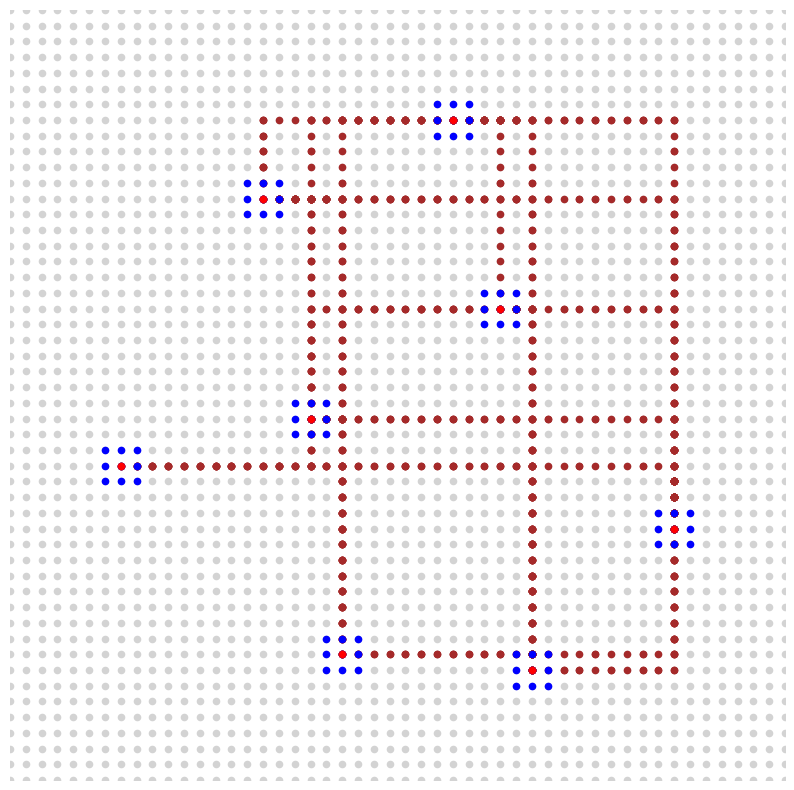

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(x_coords.min() - margin_factor * x_range, x_coords.max() + margin_factor * x_range)
ax.set_ylim(y_coords.min() - margin_factor * y_range, y_coords.max() + margin_factor * y_range)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

ax.axis('off')

grid = grid_search(x_min, x_max, y_min, y_max, points=50)

for point in grid:
    ax.scatter(point['x'], point['y'], color='lightgrey', s=20, zorder=2) 

for node_position in node_positions:
    grid_size = 50
    closest_point, points_around = get_closest_grid_point(node_position, grid, 50, 1)
    
    ax.scatter(closest_point['x'], closest_point['y'], color = 'red', s=20, zorder = 5)

    for point in points_around:
        ax.scatter(point['x'], point['y'], color = "blue", s=20, zorder = 4)

for point in points_in_connections:
    closest_point, points_around = get_closest_grid_point(point, grid, 50, 1)
    ax.scatter(closest_point['x'], closest_point['y'], color = "brown", s=20, zorder = 3)
        
plt.show()